In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import h5py
import pandas as pd
import numpy as np
import ttach as tta
from setup import tta_functions
from models import get_pretrained_model
from dataloaders import get_stl10_dataloader, get_cifar100_dataloader
from utils.gpu_utils import restrict_GPU_pytorch

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.special import softmax

import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set_style('white')
restrict_GPU_pytorch('2')

ImportError: cannot import name 'tta_functions' from 'setup' (/mnt/hdd/home/divyas/tta_learn_icml/setup.py)

In [682]:
# load model
dataset = 'svhn'
model_name = 'resnet20'
model = get_pretrained_model(model_name, dataset)
tta_model = tta.ClassificationTTAWrapperOutput(model, tta_functions, ret_all=True)
# load data
# separate data in correctly changed, incorrectly changed, and unchanged

In [683]:
# Analyzing just the difference in softmax probabilities
partial_lr = h5py.File('./' + dataset + '/hflip_modified_five_crop_scale/aggregated_outputs/val/' + model_name + '/combo/partial_lr.h5', 'r')
orig = h5py.File('./' + dataset + '/hflip_modified_five_crop_scale/aggregated_outputs/val/' + model_name + '/orig/mean.h5', 'r')

In [684]:
output_keys = [x for x in partial_lr.keys() if 'outputs' in x]
label_keys = [x[:-7] + 'labels' for x in output_keys]

tta_outputs = np.concatenate([partial_lr[ok][:] for ok in output_keys])
orig_outputs =  np.concatenate([orig[ok][:] for ok in output_keys])
labels = np.concatenate([partial_lr[lk][:] for lk in label_keys])
tta_outputs = softmax(tta_outputs, axis=1)
orig_outputs = softmax(orig_outputs, axis=1)
tta_preds = np.argmax(tta_outputs, axis=1)
orig_preds = np.argmax(orig_outputs, axis=1)
# Note: labels in each hdf5 are the true labels

In [685]:
orig_incorrect = np.where(orig_preds  != labels)[0]
orig_correct = np.where(orig_preds  == labels)[0]
tta_correct = np.where(tta_preds == labels)[0]
tta_incorrect = np.where(tta_preds != labels)[0]
nochange = np.where(orig_preds == tta_preds)[0]
# *good* corrections are where tta_outputs matches the labels and orig_outputs doesn't
good = set(tta_correct).intersection(orig_incorrect)
bad = set(tta_incorrect).intersection(orig_correct)
nochange = set(tta_correct).intersection(orig_correct)
# *bad* corrections are where orig_outputs matches the labels and 
# *fine* corrections are where tta_output
n_good = len(good)
n_bad = len(bad)
len(good), len(bad)


(223, 113)

In [686]:
len(orig_correct), len(orig_incorrect), len(tta_correct), len(tta_incorrect), len(nochange)

(24998, 1034, 25108, 924, 24885)

In [687]:
good_tta_outputs = tta_outputs[list(good)]
good_orig_outputs = orig_outputs[list(good)]
bad_tta_outputs = tta_outputs[list(bad)]
bad_orig_outputs = orig_outputs[list(bad)]

In [668]:
np.where(np.argmax(bad_tta_outputs, axis=1) == np.argmax(bad_orig_outputs, axis=1))[0]

array([], dtype=int64)

(array([ 0.,  0.,  0.,  4., 18., 52., 40., 46., 42., 80.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

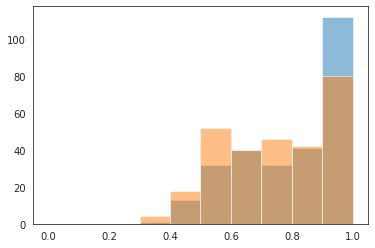

In [647]:
# Keep only highest probability 
highest_good_outputs = np.max(good_tta_outputs, axis=1)
highest_bad_outputs = np.max(bad_tta_outputs, axis=1)
plt.hist(highest_good_outputs.flatten(), bins=10, range=[0, 1], alpha=.5)
plt.hist(highest_bad_outputs.flatten(), bins=10, range=[0, 1], alpha=.5)

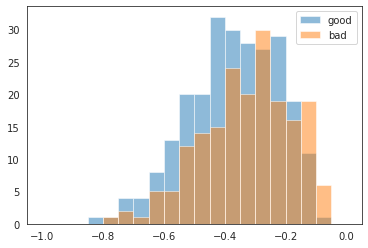

In [368]:
good_diff = good_tta_outputs - good_orig_outputs
bad_diff = bad_tta_outputs - bad_orig_outputs
plt.hist(np.min(good_diff, axis=1), bins=20, range=[-1, 0], alpha=.5, label='good')
plt.hist(np.min(bad_diff, axis=1), bins=20, range=[-1, 0], alpha=.5, label='bad')
plt.legend()
# Variance of the difference bt good/bad is a little bit lower for bad outputs

(array([ 3.,  9., 20., 37., 30., 26., 17., 23., 15.,  9.]),
 array([0.28030175, 0.35090145, 0.42150116, 0.4921009 , 0.56270057,
        0.6333003 , 0.70390004, 0.7744997 , 0.84509945, 0.9156991 ,
        0.98629886], dtype=float32),
 <a list of 10 Patch objects>)

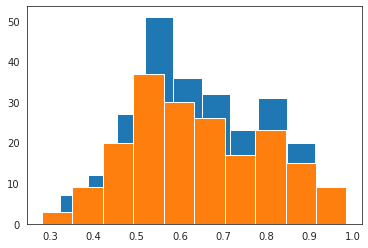

In [369]:
plt.hist(np.max(good_orig_outputs, axis=1))
plt.hist(np.max(bad_orig_outputs, axis=1))

In [370]:
# let's try and see if PCA can tell us anything about this
all_outputs = np.concatenate([good_diff, bad_diff])
all_labels = np.concatenate([[1 for x in good], [0 for x in bad]])
all_labels = np.expand_dims(all_labels, 1)
all_data = np.concatenate([all_outputs, all_labels], axis=1)
df = pd.DataFrame(all_data)
df = df.rename(columns={10: 'label'})


In [371]:
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(all_outputs)
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                          'principal component 3'])
finalDf = pd.concat([principalDf, df[['label']]], axis = 1)

[0.21554811 0.16550593 0.15437308]


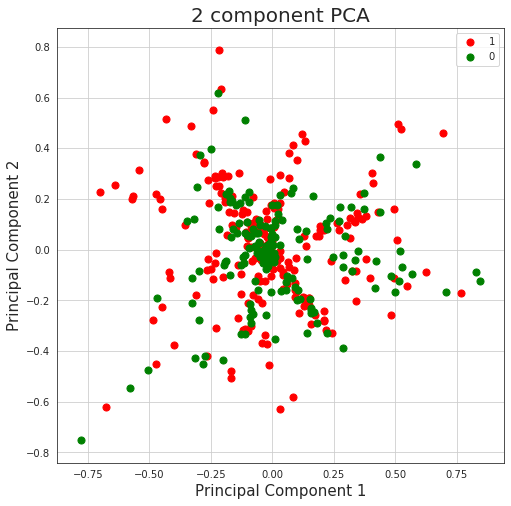

In [372]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Text(0.5, 0, 'pca-three')

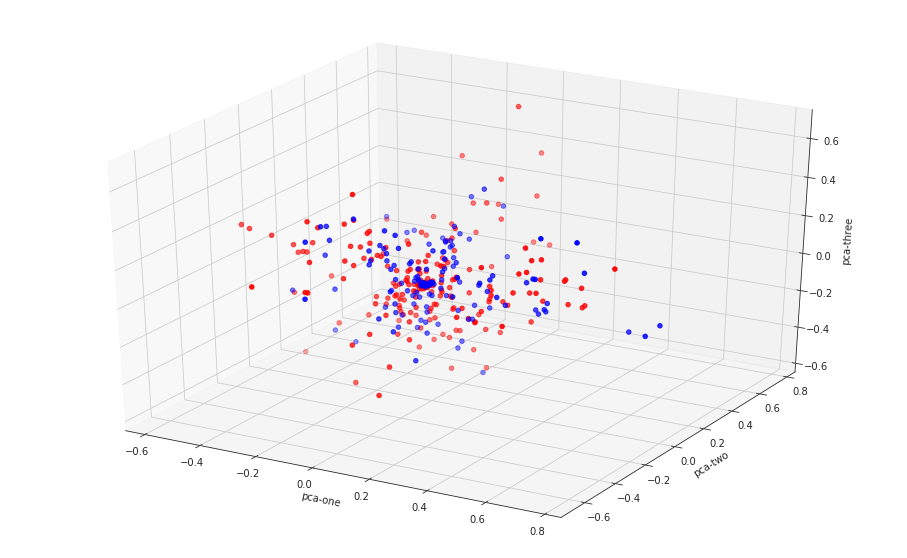

In [274]:

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
c_arr = ['r'  if (x == 1.0) else 'b' for x in list(finalDf.loc[:]['label'])]
ax.scatter(
    xs=finalDf.loc[:]["principal component 1"], 
    ys=finalDf.loc[:]["principal component 2"], 
    zs=finalDf.loc[:]["principal component 3"], 
    c=c_arr, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

In [275]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_outputs)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 365 samples in 0.000s...
[t-SNE] Computed neighbors for 365 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 365 / 365
[t-SNE] Mean sigma: 0.175925
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.181660
[t-SNE] KL divergence after 300 iterations: 0.392997


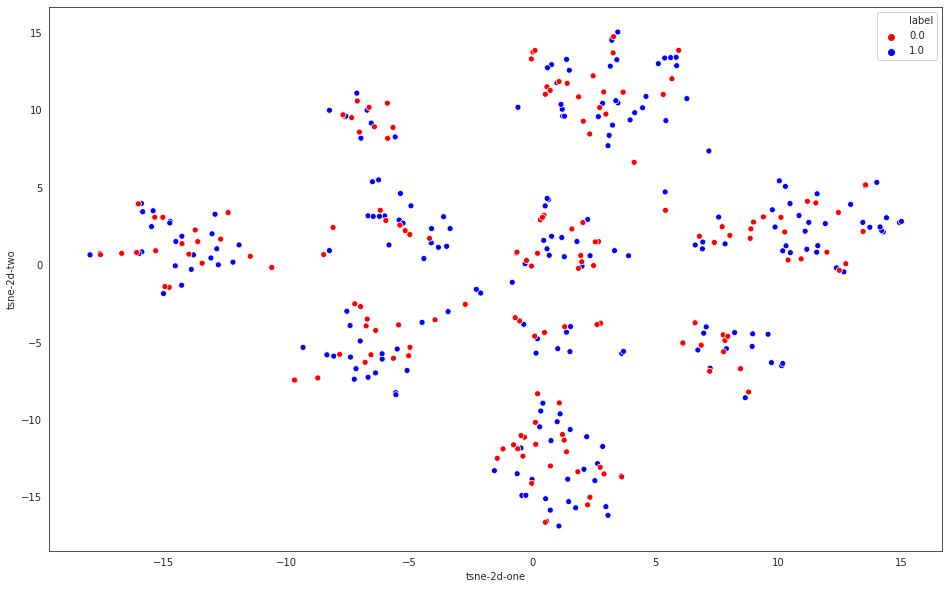

In [276]:
finalDf['tsne-2d-one'] = tsne_results[:,0]
finalDf['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=['r', 'b'],
    data=finalDf,
    legend="full"
)

(array([ 5., 19.,  9., 20.,  5., 27., 19., 22., 12., 11.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

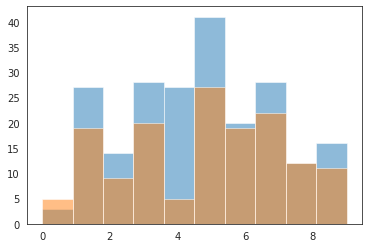

In [277]:
# Class-based histogram of which classes tta positively affects (blue) and negatively (orange)
# you see that there seems to be no class bias in terms of which classes suffer
# this is true for both the tta preds + orig preds
plt.hist(tta_preds[list(good)], alpha=.5)
plt.hist(tta_preds[list(bad)], alpha=.5)

In [278]:
# concludes looking at what we can find out from softmax probabilities. it looks like we can't
# get anything useful from just the softmax probabilities...
# next steps:
# 1. use the images themselves; are there distinctive features for these?????? UGh
# 2. use the gradients the predicted values would give you from the network? 

# Using images 

In [624]:
# load images using same dataloader in evaluate.py

dataloader = get_stl10_dataloader(train=False, batch_size=64)
img_tensors = []
for i, (images, target) in enumerate(tqdm(dataloader)):
    img_tensors.append(images)
imgs = [img.cpu().numpy() for img in img_tensors]
imgs = np.concatenate(imgs, axis=0)

Files already downloaded and verified


In [625]:
good_imgs = imgs[list(good)]
bad_imgs = imgs[list(bad)]

In [246]:
all_outputs.shape

(619, 10)

In [626]:
# do PCA + TSNE on their vgg features? or maybe i should the resnet20 features?
all_outputs = np.concatenate([good_imgs, bad_imgs], axis=0)
all_outputs = all_outputs.reshape((all_outputs.shape[0],3*96*96))
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(all_outputs)
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                          'principal component 3'])
principalDf['label'] = np.array([1 for i in good] + [0 for i in bad])

[0.17251587 0.09254643 0.07776787]


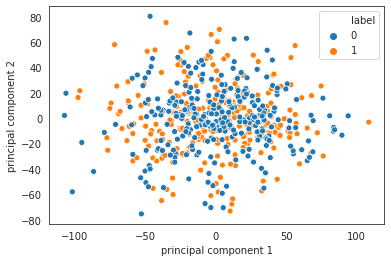

In [627]:
sns.scatterplot(x='principal component 1', y='principal component 2', hue='label', data=principalDf)

In [628]:
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.classifier = new_classifier

In [629]:
all_outputs = all_outputs.reshape(all_outputs.shape[0], 3, 96, 96)
all_outputs = torch.Tensor(all_outputs).to("cuda:0")


[0.14106105 0.07438299]


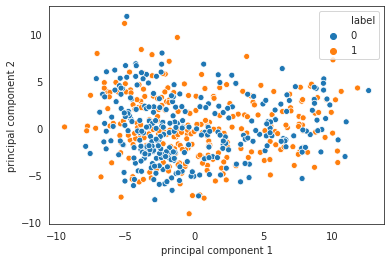

In [630]:
all_img_features = model(all_outputs).cpu().detach().numpy()
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(all_img_features)
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf['label'] = np.array([1 for i in good] + [0 for i in bad])
sns.scatterplot(x='principal component 1', y='principal component 2', hue='label', data=principalDf)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 553 samples in 0.011s...
[t-SNE] Computed neighbors for 553 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 553 / 553
[t-SNE] Mean sigma: 4.016873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.351700
[t-SNE] KL divergence after 300 iterations: 1.318962


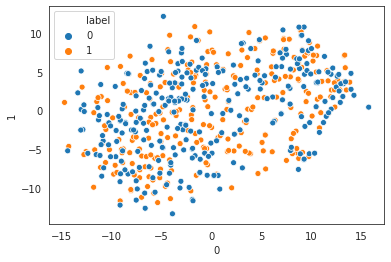

In [631]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_img_features)
df = pd.DataFrame(tsne_results)
df['label'] =  np.array([1 for i in good] + [0 for i in bad])
sns.scatterplot(x=0, y=1, hue='label', data=df)

In [638]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
X = all_img_features
y = np.array([1 for i in range(n_good)] + [0 for i in range(n_bad)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
svclassifier = SVC(kernel='rbf', class_weight='balanced', probability=True)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.5296031229668184

# Gradients

In [27]:
# Get gradients for pre-trained network for each image in the good/bad images + the loss based on 
# the TTA produced softmax probabilities and the original softmax probabilities

# Hypothesis: mean absolute gradients on the correct choice will be smaller than the 
# mean absolute gradients on bad choices

# (as shown in OOD graphs)
model_name = 'stl10_cnn'
model = get_pretrained_model(model_name, dataset)
tta_model = tta.ClassificationTTAWrapperOutput(model, tta_functions, ret_all=True)
model.train()
    

Building and initializing stl10 parameters
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (14

SVHN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)


In [28]:
def get_mean_sum_var(vals):
    vals = np.absolute(vals.flatten())
    #vals = vals.flatten()
    return np.mean(vals), np.sum(vals), np.var(vals)


In [29]:
results = []
mode = 'orig'
for i, img in enumerate(tqdm(all_outputs)):
    model.zero_grad()
    img = img.unsqueeze(0)
    if mode == 'orig':
        output = model(img)
        _, indices = output.max(1)
        index = np.array(indices.cpu())
        target = torch.LongTensor(index).to("cuda:0")
    else:
        output = tta_model(img)
        _, indices = output.max(2)
        index = np.array(indices.cpu())
        target = torch.LongTensor(index).to("cuda:0")
        output = output.squeeze(1)
        target = target.squeeze(1)
    loss = F.nll_loss(output, target)
    loss.backward()
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    l1_mean, l1_sum, l1_var = get_mean_sum_var(np.array(grads.cpu()))
    result = {'index': i, 'mean': l1_mean, 'sum': l1_sum, 'var': l1_var}
    results.append(result)
results = pd.DataFrame(results)
results['label'] = np.array([1 for i in good] + [0 for i in bad])

(-0.01, 0.05)

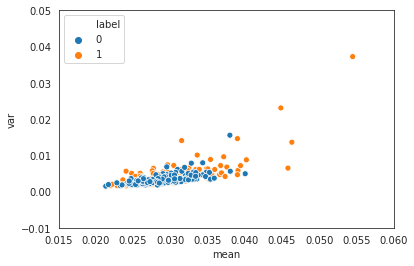

In [30]:
sns.scatterplot(x='mean', y='var', hue='label', data=results)
plt.xlim(.015, .060)
plt.ylim(-.01, .05)

(array([ 3., 32., 49., 37., 22.,  3.,  3.,  0.,  0.,  0.]),
 array([0.02 , 0.023, 0.026, 0.029, 0.032, 0.035, 0.038, 0.041, 0.044,
        0.047, 0.05 ]),
 <a list of 10 Patch objects>)

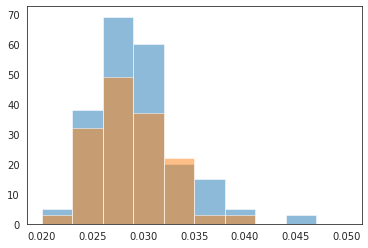

In [31]:
good_grads = results[results['label'] == 1]
bad_grads = results[results['label'] == 0]
lb, ub = .02, .05
plt.hist(good_grads['mean'], bins=10, range=[lb, ub], alpha=.5)
plt.hist(bad_grads['mean'], bins=10, range=[lb, ub], alpha=.5)

(array([ 0.,  0.,  0.,  0., 47., 78., 23.,  0.,  1.,  0.]),
 array([-9. , -8.4, -7.8, -7.2, -6.6, -6. , -5.4, -4.8, -4.2, -3.6, -3. ]),
 <a list of 10 Patch objects>)

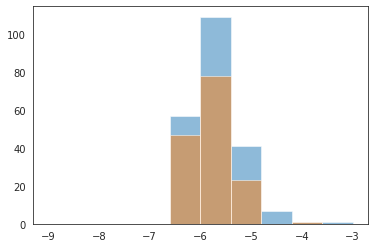

In [32]:
plt.hist(np.log(good_grads['var']), bins=10, range=[-9, -3], alpha=.5)
plt.hist(np.log(bad_grads['var']), bins=10, range=[-9, -3], alpha=.5)

In [33]:
# Ideas to try
    # pre-aggregation inputs
    # pre-computed image features instead of VGG features
    # lowest uncertainty, calcualte uncertainty using an out-of-the-box thing for networks
    # similarity to training set by another measure (not euclidean distance)

# Pre-aggregation TTA outputs

In [688]:
from augmentations import get_single_aug_idxs, get_all_idxs
all_tta_outputs = h5py.File(dataset + "/hflip_modified_five_crop_scale/model_outputs/val/" + model_name + ".h5", "r")
idxs = get_all_idxs()
idxs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [689]:
input_keys = [x for x in all_tta_outputs.keys() if 'inputs' in x]

tta_outputs = np.concatenate([all_tta_outputs[ok][:] for ok in input_keys], axis=1)
tta_outputs = tta_outputs[idxs]

In [690]:
good_tta_outputs_preagg = softmax(tta_outputs[:,list(good),:], axis=2)
bad_tta_outputs_preagg = softmax(tta_outputs[:,list(bad),:], axis=2)
good_tta_outputs_preagg = good_tta_outputs_preagg[1:]
bad_tta_outputs_preagg = bad_tta_outputs_preagg[1:]

(array([ 8.,  8., 13., 31., 15., 23.,  9.,  3.,  0.,  3.]),
 array([0.02393, 0.05304, 0.08215, 0.1113 , 0.1404 , 0.1696 , 0.1987 ,
        0.2278 , 0.2568 , 0.2861 , 0.3152 ], dtype=float16),
 <a list of 10 Patch objects>)

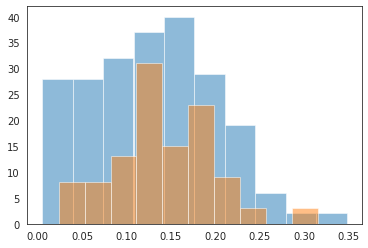

In [691]:
good_variance = np.sum(np.var(good_tta_outputs_preagg, axis=0), axis=1)
bad_variance = np.sum(np.var(bad_tta_outputs_preagg, axis=0), axis=1)
plt.hist(good_variance.flatten(), alpha=.5)
plt.hist(bad_variance.flatten(), alpha=.5)

In [692]:
# Look through the class agreement across the augmentations
bad_argmax = np.argmax(bad_tta_outputs_preagg, axis=2)
good_argmax = np.argmax(good_tta_outputs_preagg, axis=2)
all_bad_votes = []
for example in bad_argmax.T:
    votes = np.zeros(100)
    for i in range(100):
        votes[i] = len(np.where(example == i)[0])
    all_bad_votes.append(votes)
all_good_votes = []
for example in good_argmax.T:
    votes = np.zeros(100)
    for i in range(100):
        votes[i] = len(np.where(example == i)[0])
    all_good_votes.append(votes)

Text(0.5, 1.0, '# of classes the decision is divided between')

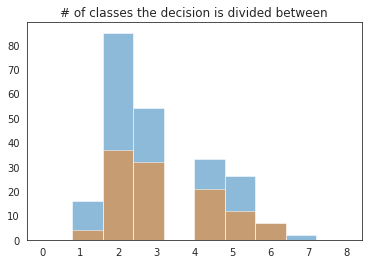

In [693]:
n_classes_good = [len(np.where(x != 0)[0]) for x in all_good_votes]
n_classes_bad = [len(np.where(x!=0)[0]) for x in all_bad_votes]
max_votes_good = [np.max(x) for x in all_good_votes]
max_votes_bad = [np.max(x) for x in all_bad_votes]

plt.hist(n_classes_good, range=[0, 8], alpha=.5)
plt.hist(n_classes_bad, range=[0, 8], alpha=.5)
plt.title("# of classes the decision is divided between")

Text(0.5, 1.0, 'Maximum # of votes for one class')

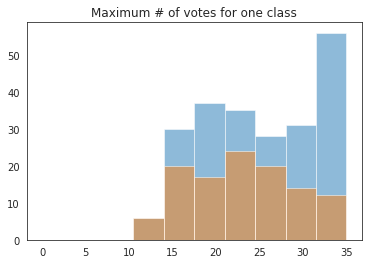

In [694]:
plt.hist(max_votes_good, range=[0, 35], alpha=.5)
plt.hist(max_votes_bad, range=[0, 35], alpha=.5)
plt.title("Maximum # of votes for one class")

(array([18., 17., 14., 21.,  9.,  8.,  6.,  9.,  2.,  0.]),
 array([0.02 , 0.027, 0.034, 0.041, 0.048, 0.055, 0.062, 0.069, 0.076,
        0.083, 0.09 ], dtype=float16),
 <a list of 10 Patch objects>)

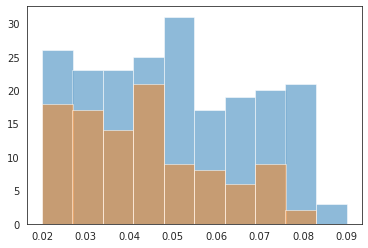

In [695]:
# Sum of variances across classes
good_class_var = np.median(np.var(good_tta_outputs_preagg, axis = 2), axis=0)
bad_class_var = np.median(np.var(bad_tta_outputs_preagg, axis=2), axis=0)
plt.hist(good_class_var, range=[.02, .09], alpha=.5)
plt.hist(bad_class_var, range=[.02, .09], alpha=.5)

In [703]:
good_tta_outputs_reshaped = good_tta_outputs_preagg.reshape((good_tta_outputs_preagg.shape[1], 350))
bad_tta_outputs_reshaped = bad_tta_outputs_preagg.reshape((bad_tta_outputs_preagg.shape[1], 350))
all_tta_outputs_reshaped = np.concatenate([good_tta_outputs_reshaped, 
                                           bad_tta_outputs_reshaped])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(all_tta_outputs_reshaped)
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents
            , columns = ['pc1', 'pc2'])
n_good = len(good_tta_outputs_reshaped)
n_bad = len(bad_tta_outputs_reshaped)
principalDf['label'] = np.array([1 for i in range(n_good) ] + [0 for i in range(n_bad)])

[0.01626517 0.01559497]


10


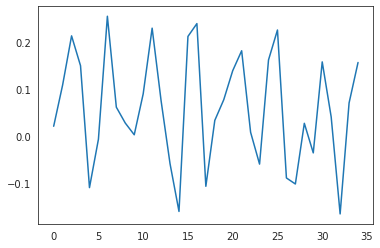

In [697]:
pc1 = pca.components_[0]
pc1_comps = [[pc1[10*i + j] for i in range(35)] for j in range(10)]
print(len(pc1_comps))
#[plt.scatter(np.arange(35), pc1) for pc1 in pc1_comps]
plt.plot(pc1_comps[1])

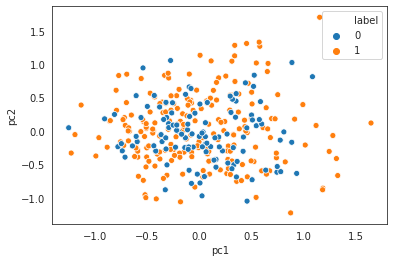

In [704]:
sns.scatterplot(x='pc1', y='pc2', hue='label', data=principalDf)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 336 samples in 0.001s...
[t-SNE] Computed neighbors for 336 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 336 / 336
[t-SNE] Mean sigma: 0.205965
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.208111
[t-SNE] KL divergence after 300 iterations: 0.328653


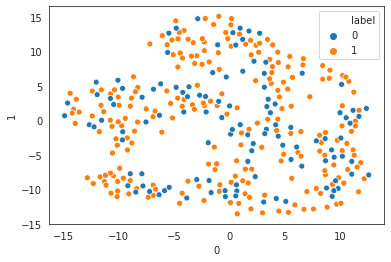

In [702]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(principalComponents)
df = pd.DataFrame(tsne_results)
df['label'] =  np.array([1 for i in range(n_good) ] + [0 for i in range(n_bad)])
sns.scatterplot(x=0, y=1, hue='label', data=df)

In [700]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
X = principalComponents
y = np.array([1 for i in range(n_good)] + [0 for i in range(n_bad)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
svclassifier = SVC(kernel='rbf', class_weight='balanced', probability=True)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.5522222222222223

In [568]:
print(classification_report(y_test, svclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.96      0.92      0.94        52

    accuracy                           0.91        70
   macro avg       0.88      0.91      0.89        70
weighted avg       0.92      0.91      0.92        70



#### all_tta_outputs_reshaped.shape

##### from tamura import coarseness, contrast, directionality
good_coarse = [coarseness(np.mean(img, axis=0), 5) for img in good_imgs]
bad_coarse = [coarseness(np.mean(img, axis=0), 5) for img in bad_imgs]
plt.hist(good_coarse)
plt.hist(bad_coarse)

# Looking at what goes wrong with the wrong predictions

(array([11., 22., 28., 24., 27., 14., 12.,  7.,  2.,  2.]),
 array([0.05875362, 0.12586652, 0.19297941, 0.2600923 , 0.32720518,
        0.39431807, 0.46143097, 0.5285439 , 0.59565675, 0.6627697 ,
        0.72988254], dtype=float32),
 <a list of 10 Patch objects>)

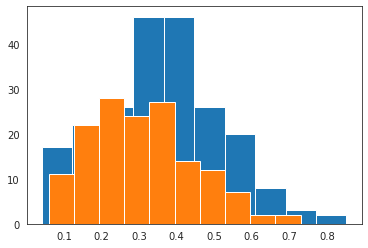

In [131]:
plt.hist(np.max(good_orig_outputs - good_tta_outputs, axis=1))
plt.hist(np.max(bad_orig_outputs - bad_tta_outputs, axis=1))

In [149]:
np.sum(softmax(np.mean(tta_outputs[:,list(bad),:], axis=0), axis=1) -  bad_tta_outputs)

-0.010783669

([<matplotlib.axis.XTick at 0x7f9f0db8e950>,
 <a list of 10 Text xticklabel objects>)

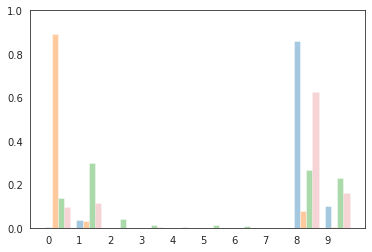

In [346]:
img_idx = 10
barWidth = .2
r1 = np.arange(10)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1,bad_tta_outputs_preagg[0,img_idx,:],width=barWidth,alpha=.4, edgecolor='white', label='var1')
plt.bar(r2,bad_tta_outputs_preagg[1,img_idx,:],width=barWidth, alpha=.4,
       edgecolor='white', label='var1')
plt.bar(r3,bad_tta_outputs[img_idx], alpha=.4, width=barWidth,
       edgecolor='white', label='var1')
plt.bar(r4,bad_orig_outputs[img_idx],width=barWidth, alpha=.2,
        edgecolor='white', label='var1')
plt.ylim(0, 1)
plt.xticks(np.arange(10))

([<matplotlib.axis.XTick at 0x7f9f0dafba90>,
 <a list of 10 Text xticklabel objects>)

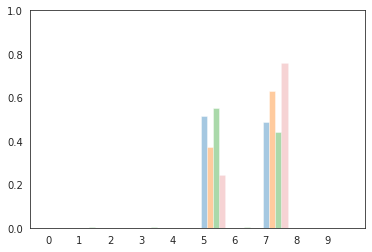

In [347]:
img_idx = 150
barWidth = .2
r1 = np.arange(10)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1,good_tta_outputs_preagg[0,img_idx,:],width=barWidth,alpha=.4, edgecolor='white', label='var1')
plt.bar(r2,good_tta_outputs_preagg[1,img_idx,:],width=barWidth, alpha=.4,
       edgecolor='white', label='var1')
plt.bar(r3,good_tta_outputs[img_idx], alpha=.4, width=barWidth,
       edgecolor='white', label='var1')
plt.bar(r4,good_orig_outputs[img_idx],width=barWidth, alpha=.2,
        edgecolor='white', label='var1')
plt.ylim(0, 1)
plt.xticks(np.arange(10))

(array([  0.,   0.,   0.,   7.,   8.,  29.,  27.,  31.,  29., 117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float16),
 <a list of 10 Patch objects>)

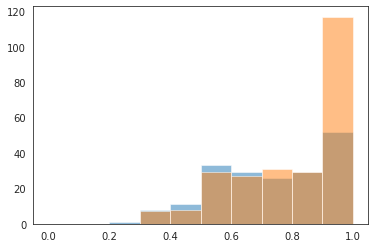

In [387]:
bad_aug_tta_outputs_preagg = bad_tta_outputs_preagg[10]
good_aug_tta_outputs_preagg = good_tta_outputs_preagg[30]
#bad_aug_tta_outputs_preagg = bad_aug_tta_outputs_preagg
#good_aug_tta_outputs_preagg = softmax(good_aug_tta_outputs_preagg, axis=1)

plt.hist(np.max(bad_aug_tta_outputs_preagg, axis=1), bins=10, range=[0, 1], alpha=.5)
plt.hist(np.max(good_aug_tta_outputs_preagg, axis=1), bins=10, range=[0, 1], alpha=.5)
#plt.hist(np.var(bad_aug_tta_outputs_preagg, axis=1), bins=10,  alpha=.5, range=[0, .1])
#plt.hist(np.var(good_aug_tta_outputs_preagg, axis=1), bins=10,  alpha=.5, range=[0, .1])

In [1]:
orig_outputs.shape

NameError: name 'orig_outputs' is not defined